## Preprocessing scRNA-seq data

### Coding lecture

#### Why preprocessing the data?

Before starting the analysis, it is important to ensure that (a) no low-quality samples or measurements will negatively affect the results, and (b) the data have been transformed in a way that is appropriate for the analysis to perform.

We will perform the preprocessing of the T-cell use-case data using the scanpy package. Preprocessing is such an important step in the analysis that scanpy has a dedicate module for it, namely `pp`.

First, let's import the relevant packages and load the data

In [8]:
from pathlib import Path
dataset_path = Path("../part-1")

In [9]:
# packages
import numpy as np
import pandas as pd
import scanpy as sc 

# loading the T-cell data
scdr = sc.read_h5ad( dataset_path / 'scdr.h5ad')
(scdr.n_obs, scdr.n_vars)

(5016, 20953)

#### Basic quality control

We will start by removing cells where fewer than 200 expressed genes, as these samples may probably be debris or dead cells. This threshold is purely empirical, and it must be adjusted depending on the specific experiment.

In [10]:
# filtering cells
sc.pp.filter_cells(scdr, min_genes=200)
(scdr.n_obs, scdr.n_vars)

(5016, 20953)

No cells were eliminated this time!

Similarly, we will remove genes that are expressed only in 3 or fewer cells. Most likely such genes would not contribute significantly to the analyses, and would only aggravate the computational requirements

In [11]:
# filtering genes
sc.pp.filter_genes(scdr, min_cells=3)
(scdr.n_obs, scdr.n_vars)

(5016, 14699)

Circa 6000 genes were filtered out, for having being detected in very few cells.

We will now compute the percentage of reads that originates from mitochondrial genes. An excess of mitochondrial reads usually indicate RNA contamination:

In [12]:
# the names of mitochondrial genes starts with 'MT-'. Let's create a boolean column in the var data frame to identify them
scdr.var['mt'] = scdr.var_names.str.startswith('MT-')

# The following function will compute the percentage of mithocondrial reads for each cell
sc.pp.calculate_qc_metrics(scdr, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Let's plot the distribution of relevant quality control quantities:

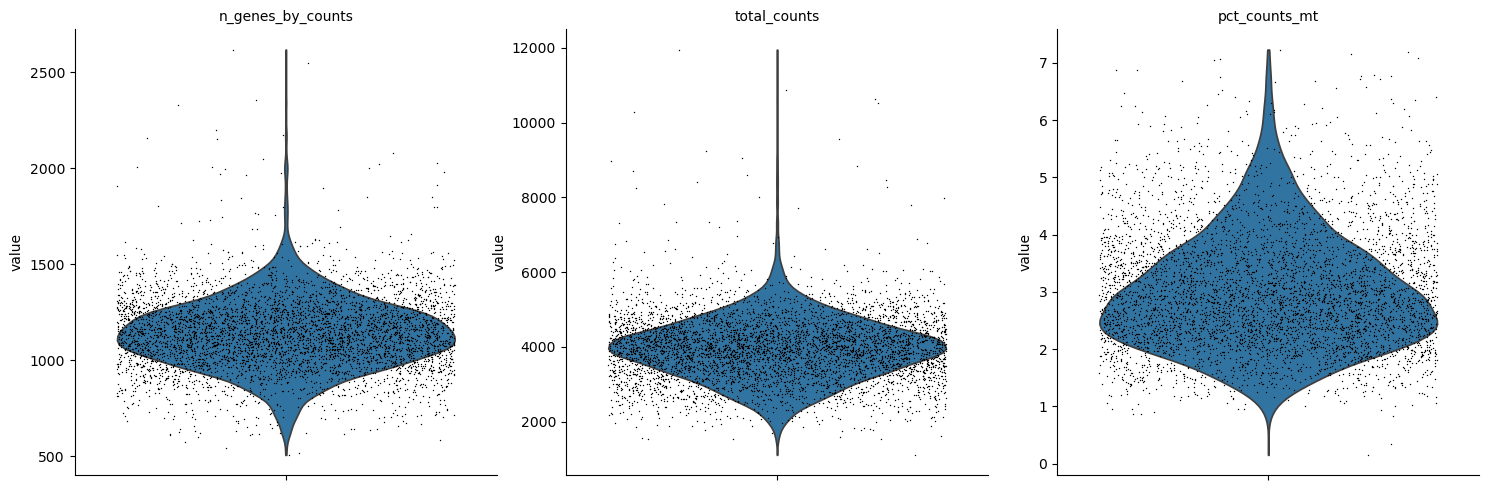

In [13]:
# quality control violin plots
sc.pl.violin(scdr, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

The first plot reports how many genes are expressed for each cell. The second plot provides the distribution of the total number of reads across cells, while the third plot illustrate the percentage of mitochondrial reads. 

Notice that all distribution are skewed torwards higher values. In the case of the first two plots, these might be doublets, meaning two or more cells mistakenly sequenced as a single cell. In the case of mitochondrial reads percentage, the dots above 5% might correspond to droplets contaminated with external RNA.

We may want to filter out these anomalous samples. Once again we will define some thresholds, heuristically.

In [14]:
# filtering out possible doublets
scdr = scdr[scdr.obs.n_genes_by_counts < 2000, :].copy()
(scdr.n_obs, scdr.n_vars)

(5001, 14699)

In [15]:
# filtering out cells possibly affected by contamination
scdr = scdr[scdr.obs.pct_counts_mt < 5, :].copy()
(scdr.n_obs, scdr.n_vars)

(4783, 14699)

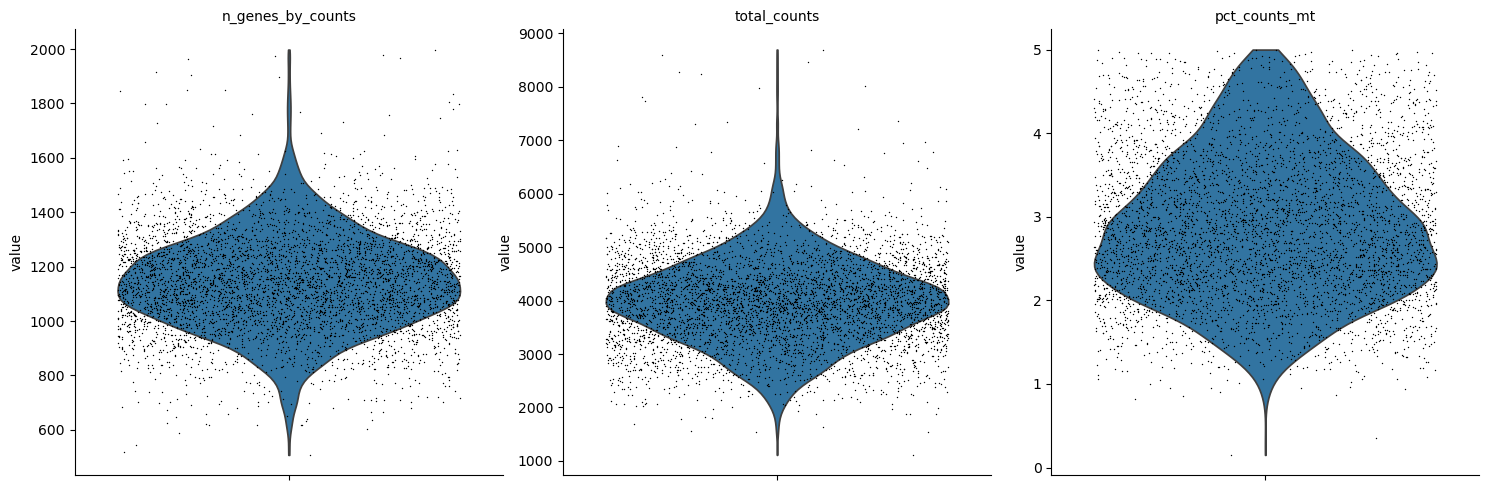

In [16]:
# plotting again the quality control violin plots
sc.pl.violin(scdr, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

The three distribution appear less skewed, and we can now assume that we discarded the most problematic samples.

It is important to notice that thresholding is the most basic approach for eliminating debris, doublets and conntamination. Many algorithms, more sophisticated and arguably more effective, have been proposed in the literature. We discuss some of them in the reading material provided in this same module.

#### Standard preprocessing pipeline

After quality control, preprocessing can start. We usually refer to a preprocessing "pipeline" because the whole task is broken down in a number of steps: normalization, variance-stabilization transformation, regressing out confounders, scaling. Depending on the specific study at hand, this standard pipeline can be altered in different ways. Let's see how these main steps operates on our data. 

The first step is correcting for the different sequencing depth characterizing each cell. To assess the extent of this issue, let's compute the total number of reads for each cell:

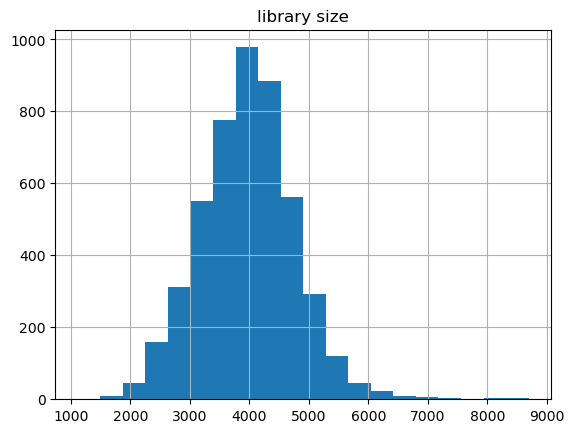

In [17]:
# summing reads for each cell
library_size = scdr.X.sum(axis = 1)

# transforming in a pandas data frame
library_size = pd.DataFrame({'library size':np.array(library_size).flatten()}, index=scdr.obs_names)

# plotting the library size distribution
tmp = library_size.hist(bins=20)


What we see here is that most of the cell have around 4000 reads in total, however extreme cases up to 8000 exist. This disparity does not allow to compare expression levels of the same gene across different samples: a gene which has the same expression between two cells would appear more expressed in the cell with more reads.

The `normalize_total` function levels down these disparities, by normalizing all expression levels as if the same number of reads were measured for each cell.

In [18]:
# normalization. After normalization each cell will have approximately 1e4 normalized reads
sc.pp.normalize_total(scdr, target_sum=1e4)

# new library size
library_size = scdr.X.sum(axis = 1)
(library_size.min(), library_size.max())

(9999.843, 10000.176)

As we can see all the cell have a normalized library size equal to 10000, up to rounding error.

Let's now have a look to what the distribution of the new values look like. We remove the zero values, which would other wise dominate the plot.

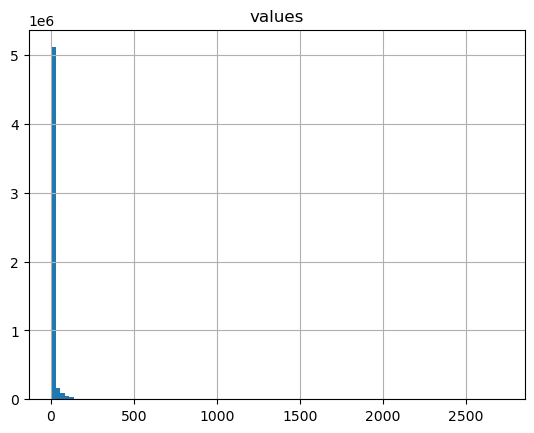

In [19]:
# histogram of all values
tmp = np.array(scdr.X.todense()).flatten()
tmp = tmp[tmp > 0]
tmp = pd.DataFrame({'values': tmp}).hist(bins=100)

Clearly, most of the values are very low, quite close to zero, while a small fraction of the values can be quite high. Such a skewed distribution can create issues during the analysis, especially for methods assuming close-to-normalty distributions.

One possible solution is to log-transform the values, so that to reduce the higher values to a more manageable range. A small offset is added to the values before log-transforming so that to avoid taking the logarith of zero.

In [20]:
# log transforming the values
sc.pp.log1p(scdr)

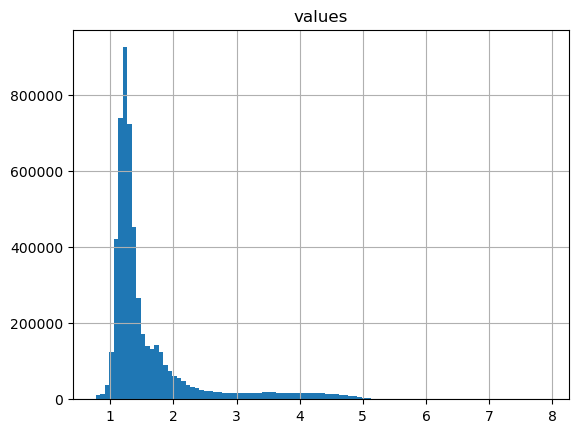

In [21]:
# histogram of all values
tmp = np.array(scdr.X.todense()).flatten()
tmp = tmp[tmp > 0]
tmp = pd.DataFrame({'values': tmp}).hist(bins=100)

While still far from an optimal normal distribution, the values are now much less dispersed.

Before proceeding further, we will now identify the most variable genes, and we will operate from now on only on this subset. The reason behind this is that these genes are likely to retain most of the signal present in the data, while at the same time this will speed up the following computations.

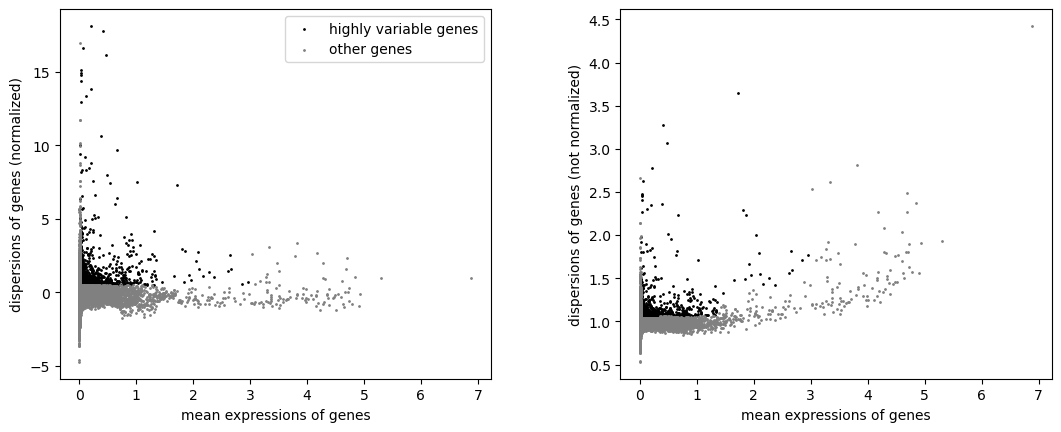

In [22]:
# identifying the genes with the highest variation
sc.pp.highly_variable_genes(scdr)
sc.pl.highly_variable_genes(scdr)

These two plots convey the same information: when the average expression level is contrasted against expession values' dispersions, some gene are cleary on the top side, meaning that their dispersion is greater than the average one. These are the genes we want to focus on.

In [23]:
# what is the percentage of highly variable genes?
print('%.1f' % np.round(scdr.var.highly_variable.sum()/scdr.n_vars * 100, 3) + '%')

10.3%


We will now store the current status of the whole scdr object within the "raw" field. In this way we will be able to go back to this point if we need to. 

In [24]:
# current status of the data stored in "raw"
scdr.raw = scdr.copy()

We can now safely restrict the `X` matrix to the highly variable genes

In [25]:
# selecting only the most variable genes
scdr = scdr[:, scdr.var.highly_variable].copy()
scdr.n_vars

1517

Last but not least, we need to scale our data. This means to that we will subtract from each gene its average value, and we will divide it by its standard variation. This operation will bring all genes to the same "order of magnitude", a condition needed for the correct operation of same of the algorithms we will apply on the data from now on, mainly PCA.

In [26]:
# scaling
sc.pp.scale(scdr, max_value=10)

Here what the distribution of one gene, e.g., PASK, looks like after scaling

0.0 1.0


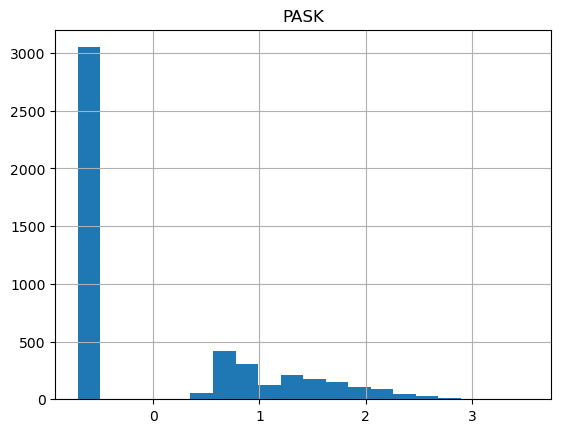

In [27]:
# distribution of the PASK gene after scaling. 
tmp = pd.DataFrame({'PASK':scdr[:, 'PASK'].X.flatten()}).hist(bins=20)

# printing the average value and standard deviation of PASK
print(np.round(scdr[:, 'PASK'].X.mean()), np.round(scdr[:, 'PASK'].X.std()))

Done! Our data is duly preprocessed. In the next coding lesson we will use these data for identifying the cell types contained in our sample.

In [28]:
# saving the data
scdr.write_h5ad('scdr_preprocessed.h5ad')